In [1]:
import sys

# resolve path for notebook
sys.path.append('../')

In [2]:
import gym
import math
import torch
import pyglet
import random
import minihack

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from nle import nethack
from collections import deque

from torch.autograd import Variable
from torch.distributions import Categorical


from environments.QuestEnvironment import QuestEnvironment

In [3]:
# if there is a Cuda GPU, then we want to use it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
num_episodes = 1000
max_steps = 5000
alpha = 0.001
alpha = 0.00001
gamma = 0.9999
epsilon = 1e-12
epsilon = 1e-1
OBS_SPACE = 'glyphs_crop'
#OBS_SPACE = 'blstats'
seed = 99
verbose = False
intermediate_plots = False

In [5]:
env = QuestEnvironment().create(
    reward_lose = -100,
    reward_win = 100,
    penalty_step = -0.1,
    penalty_time = -0.001,
    max_episode_steps = max_steps,
    seed = seed
)

In [6]:
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
env.seed(seed)

(99, 8579092592894200644, False)

In [7]:
class PolicyValueNetwork:

    def __init__(self, env, alpha):

        if len(env.observation_space.spaces[OBS_SPACE].shape) == 1:
            self.obs_space = env.observation_space.spaces[OBS_SPACE].shape[0]
        else:
            self.obs_space = env.observation_space.spaces[OBS_SPACE].shape[0] * \
                        env.observation_space.spaces[OBS_SPACE].shape[1]

        self.policy_net = torch.nn.Sequential(
            torch.nn.Linear(self.obs_space, self.obs_space*2),
            torch.nn.ReLU(),

            # hidden layers
            torch.nn.Linear(self.obs_space*2, self.obs_space*2),
            torch.nn.ReLU(),

            torch.nn.Linear(self.obs_space*2, env.action_space.n),
            torch.nn.Softmax(dim = -1)
        )

        self.policy_optimizer = torch.optim.Adam(self.policy_net.parameters(), lr = alpha)

        self.value_net = torch.nn.Sequential(
            torch.nn.Linear(self.obs_space, self.obs_space*2),
            torch.nn.ReLU(),

            # hidden layers
            torch.nn.Linear(self.obs_space*2, self.obs_space*2),
            torch.nn.ReLU(),

            torch.nn.Linear(self.obs_space*2, self.obs_space),
            torch.nn.ReLU(),
            torch.nn.Linear(self.obs_space, 1)
        )

        self.value_optimizer = torch.optim.Adam(self.value_net.parameters(), lr = alpha)


nn = PolicyValueNetwork(env, alpha)

In [8]:
visit_counts = dict()
coord_rewards = dict()

def get_exploration_reward(state, reward):
    s = state['blstats']

    #return reward
    coords = (int(s[0]), int(s[1]))

    if coords not in visit_counts:
        visit_counts[coords] = 1
        #return 0.001
        coord_rewards[coords] = reward
    else:
        #return 0
        visit_counts[coords] += 1
        coord_rewards[coords] += reward

    return -0.001 * visit_counts[coords]

    r = 0
    r += coord_rewards[coords] / visit_counts[coords]
    r += 0.01 * math.sqrt( \
        (math.log(visit_counts[coords])) \
        / \
        visit_counts[coords])

    return r

In [9]:
def convert_observation(obs):
    obs = obs[OBS_SPACE]
    obs = torch.tensor(obs, dtype=torch.float)  
    obs = torch.flatten(obs)
    obs = torch.reshape(obs, (1, obs.shape[0]))
    obs = torch.nn.functional.normalize(obs, p=2.0, dim=1, eps=epsilon, out=None)
    return obs

In [10]:
action_text = [
    'EAST', 'NORTH', 'SOUTH', 'WEST', 
    #'UP', 
    'DOWN', 
    #'OPEN', 
    #'MOVE',
    'EAT',
    'PICKUP'
    ]


Actions Taken:
- SOUTH: 567
- NORTH: 533
- PICKUP: 595
- EAT: 506
- EAST: 578
- DOWN: 516
- WEST: 507

Messages Received:
- Hello Agent, welcome to NetHack!  You are a neutral human Caveman.: 1
- : 978
- There is nothing here to pick up.: 567
- You dont have anything to eat.: 506
- Its solid stone.: 1136
- The stairs are solidly fixed to the floor.: 28
- You cant go down here.: 516
- You are beginning to feel hungry.: 1
- You are beginning to feel weak.: 1
- You faint from lack of food.  You regain consciousness.: 44
- You can hear again.: 13
- You regain consciousness.: 11


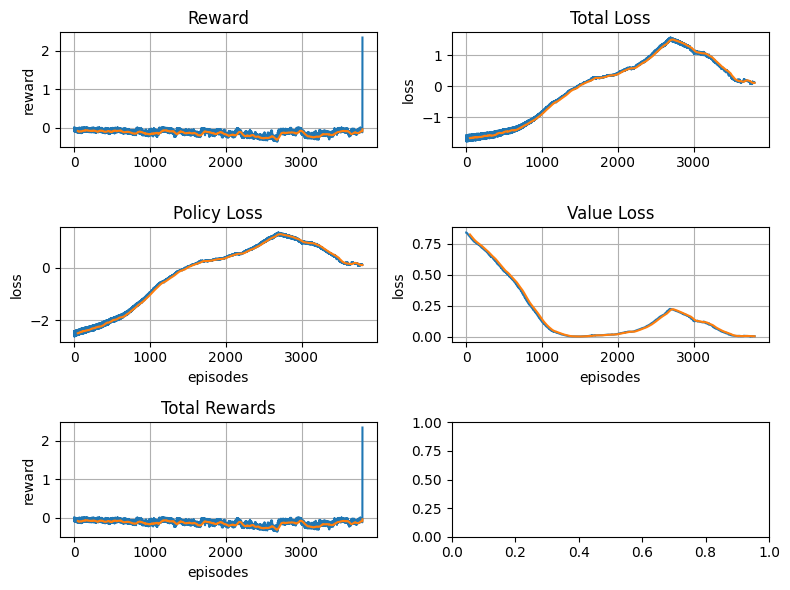


Actions Taken:
- SOUTH: 1124
- NORTH: 1035
- PICKUP: 1155
- EAT: 998
- EAST: 1104
- DOWN: 1019
- WEST: 1003

Messages Received:
- Hello Agent, welcome to NetHack!  You are a neutral human Caveman.: 2
- : 1956
- There is nothing here to pick up.: 1096
- You dont have anything to eat.: 998
- Its solid stone.: 2168
- The stairs are solidly fixed to the floor.: 59
- You cant go down here.: 1019
- You are beginning to feel hungry.: 2
- You are beginning to feel weak.: 2
- You faint from lack of food.  You regain consciousness.: 88
- You can hear again.: 26
- You regain consciousness.: 22


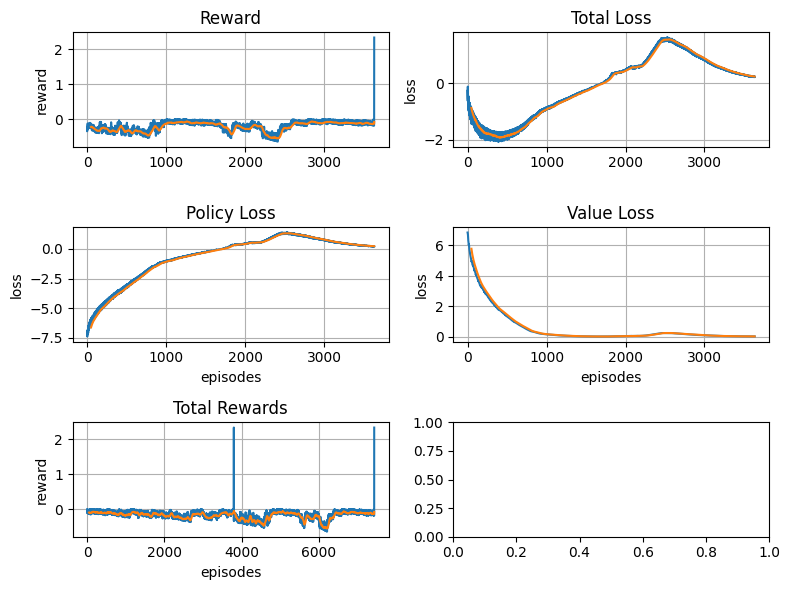


Actions Taken:
- SOUTH: 1662
- NORTH: 1482
- PICKUP: 1658
- EAT: 1468
- EAST: 1638
- DOWN: 1499
- WEST: 1490

Messages Received:
- Hello Agent, welcome to NetHack!  You are a neutral human Caveman.: 3
- : 2934
- There is nothing here to pick up.: 1583
- You dont have anything to eat.: 1468
- Its solid stone.: 3125
- The stairs are solidly fixed to the floor.: 75
- You cant go down here.: 1499
- You are beginning to feel hungry.: 3
- You are beginning to feel weak.: 3
- You faint from lack of food.  You regain consciousness.: 132
- You can hear again.: 39
- You regain consciousness.: 33


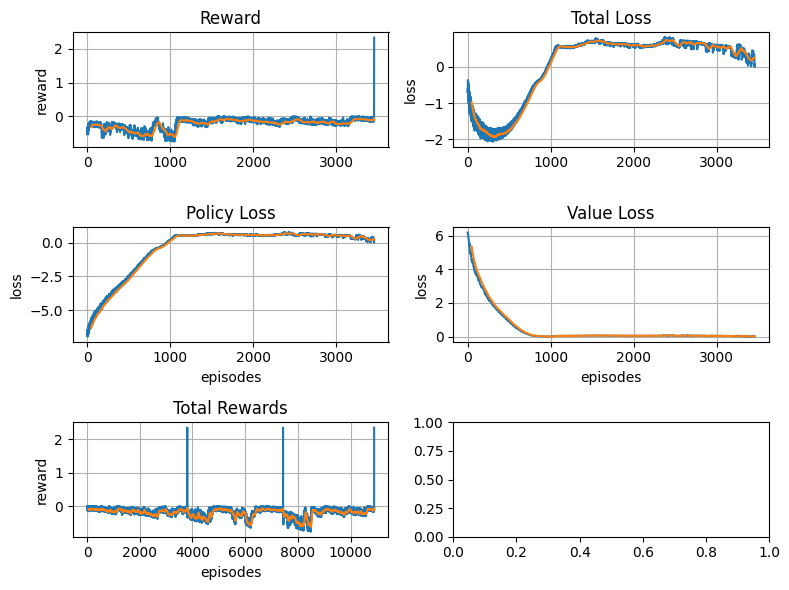


Actions Taken:
- SOUTH: 2075
- NORTH: 1817
- PICKUP: 2001
- EAT: 1792
- EAST: 2033
- DOWN: 1878
- WEST: 1812

Messages Received:
- Hello Agent, welcome to NetHack!  You are a neutral human Caveman.: 4
- : 3761
- There is nothing here to pick up.: 1920
- You dont have anything to eat.: 1792
- Its solid stone.: 3628
- The stairs are solidly fixed to the floor.: 78
- You cant go down here.: 1878
- You are beginning to feel hungry.: 4
- You are beginning to feel weak.: 3
- You faint from lack of food.  You regain consciousness.: 132
- You can hear again.: 39
- You regain consciousness.: 33
- The door resists!: 2
- The door opens.: 2
- Its a wall.: 118
- You see here a horn.: 10
- You see here an iron wand.: 1
- f - an iron wand.: 1
- g - a horn.: 1
- It wont come off the hinges.: 1


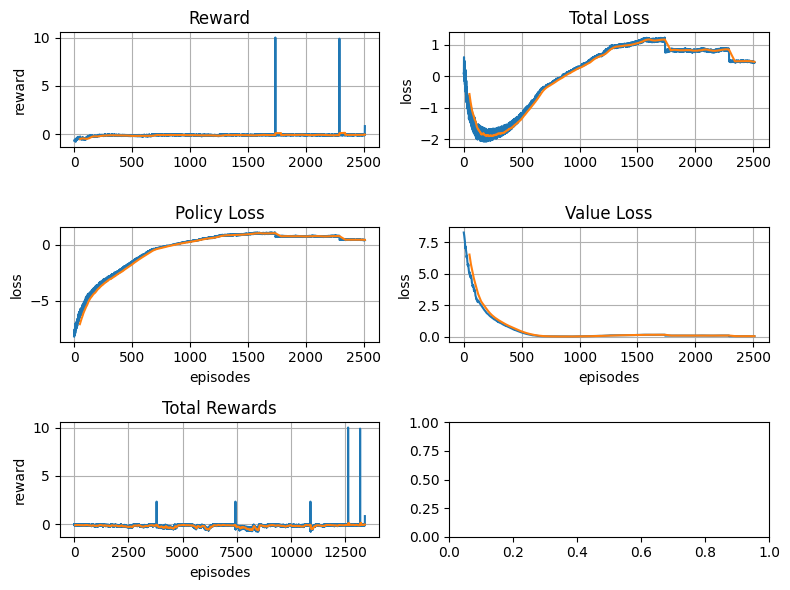


Actions Taken:
- SOUTH: 2657
- NORTH: 2319
- PICKUP: 2522
- EAT: 2268
- EAST: 2560
- DOWN: 2332
- WEST: 2343

Messages Received:
- Hello Agent, welcome to NetHack!  You are a neutral human Caveman.: 5
- : 4739
- There is nothing here to pick up.: 2420
- You dont have anything to eat.: 2268
- Its solid stone.: 4721
- The stairs are solidly fixed to the floor.: 99
- You cant go down here.: 2332
- You are beginning to feel hungry.: 5
- You are beginning to feel weak.: 4
- You faint from lack of food.  You regain consciousness.: 176
- You can hear again.: 52
- You regain consciousness.: 44
- The door resists!: 2
- The door opens.: 2
- Its a wall.: 118
- You see here a horn.: 10
- You see here an iron wand.: 1
- f - an iron wand.: 1
- g - a horn.: 1
- It wont come off the hinges.: 1


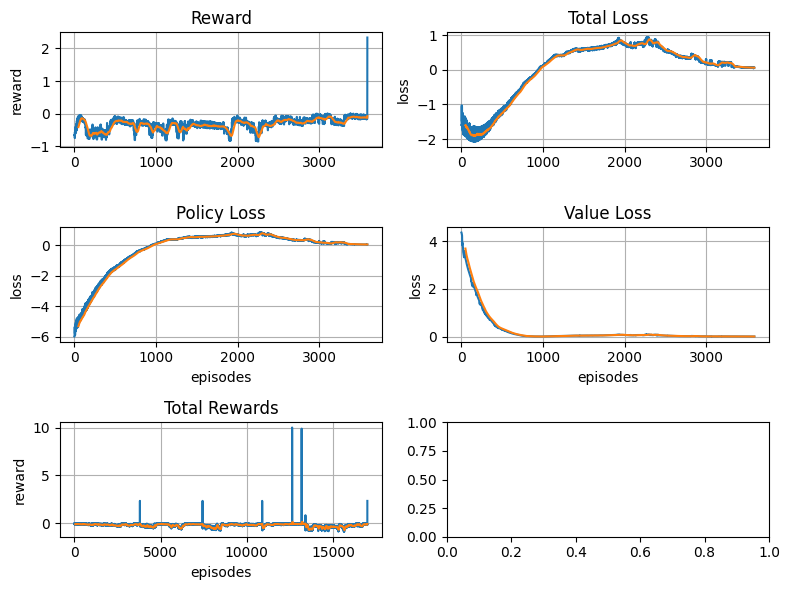


Actions Taken:
- SOUTH: 3206
- NORTH: 2818
- PICKUP: 3048
- EAT: 2807
- EAST: 3124
- DOWN: 2781
- WEST: 2812

Messages Received:
- Hello Agent, welcome to NetHack!  You are a neutral human Caveman.: 6
- : 5717
- There is nothing here to pick up.: 2946
- You dont have anything to eat.: 2807
- Its solid stone.: 5753
- The stairs are solidly fixed to the floor.: 99
- You cant go down here.: 2781
- You are beginning to feel hungry.: 6
- You are beginning to feel weak.: 5
- You faint from lack of food.  You regain consciousness.: 220
- You can hear again.: 65
- You regain consciousness.: 55
- The door resists!: 2
- The door opens.: 2
- Its a wall.: 118
- You see here a horn.: 10
- You see here an iron wand.: 1
- f - an iron wand.: 1
- g - a horn.: 1
- It wont come off the hinges.: 1


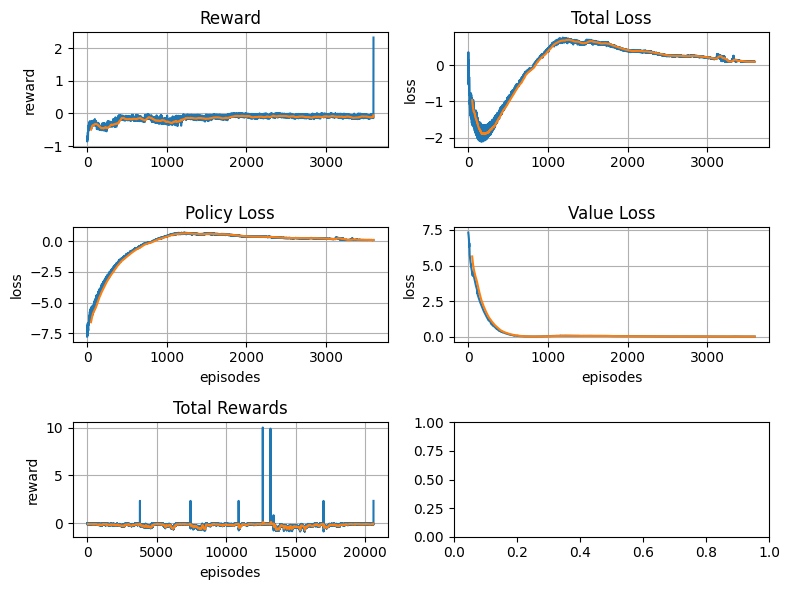


Actions Taken:
- SOUTH: 3781
- NORTH: 3288
- PICKUP: 3630
- EAT: 3293
- EAST: 3692
- DOWN: 3272
- WEST: 3276

Messages Received:
- Hello Agent, welcome to NetHack!  You are a neutral human Caveman.: 7
- : 6695
- There is nothing here to pick up.: 3516
- You dont have anything to eat.: 3293
- Its solid stone.: 6781
- The stairs are solidly fixed to the floor.: 111
- You cant go down here.: 3272
- You are beginning to feel hungry.: 7
- You are beginning to feel weak.: 6
- You faint from lack of food.  You regain consciousness.: 264
- You can hear again.: 78
- You regain consciousness.: 66
- The door resists!: 2
- The door opens.: 2
- Its a wall.: 118
- You see here a horn.: 10
- You see here an iron wand.: 1
- f - an iron wand.: 1
- g - a horn.: 1
- It wont come off the hinges.: 1


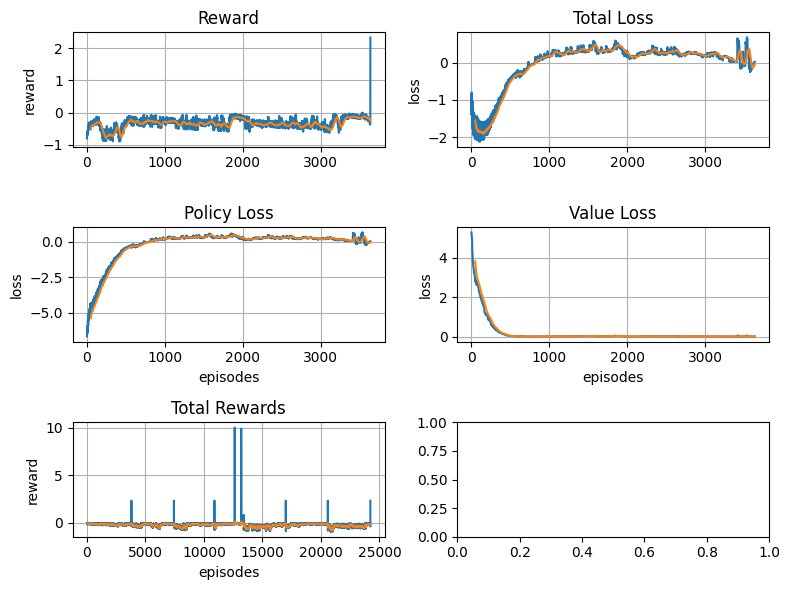


Actions Taken:
- SOUTH: 4387
- NORTH: 3768
- PICKUP: 4126
- EAT: 3759
- EAST: 4278
- DOWN: 3710
- WEST: 3703

Messages Received:
- Hello Agent, welcome to NetHack!  You are a neutral human Caveman.: 8
- : 7673
- There is nothing here to pick up.: 4012
- You dont have anything to eat.: 3759
- Its solid stone.: 7831
- The stairs are solidly fixed to the floor.: 111
- You cant go down here.: 3710
- You are beginning to feel hungry.: 8
- You are beginning to feel weak.: 7
- You faint from lack of food.  You regain consciousness.: 308
- You can hear again.: 91
- You regain consciousness.: 77
- The door resists!: 2
- The door opens.: 2
- Its a wall.: 118
- You see here a horn.: 10
- You see here an iron wand.: 1
- f - an iron wand.: 1
- g - a horn.: 1
- It wont come off the hinges.: 1


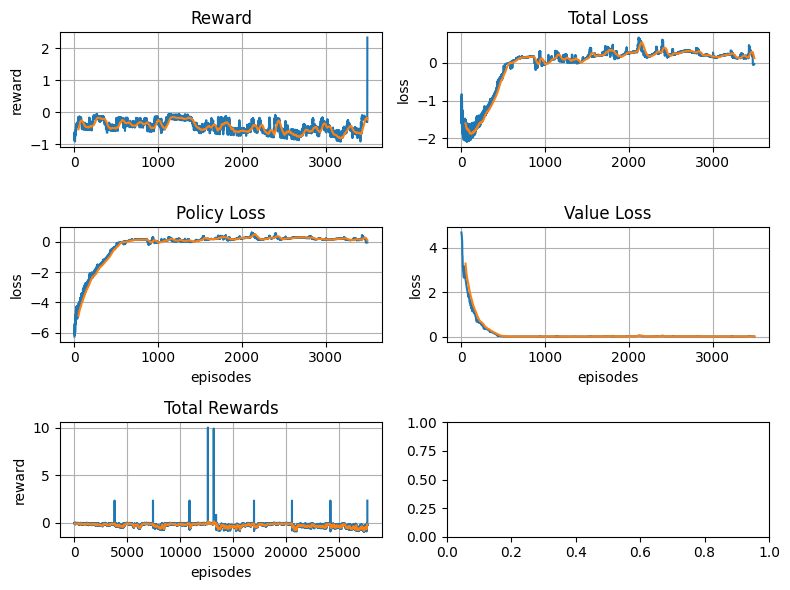


Actions Taken:
- SOUTH: 5011
- NORTH: 4293
- PICKUP: 4711
- EAT: 4239
- EAST: 4851
- DOWN: 4212
- WEST: 4155

Messages Received:
- Hello Agent, welcome to NetHack!  You are a neutral human Caveman.: 9
- : 8651
- There is nothing here to pick up.: 4595
- You dont have anything to eat.: 4239
- Its solid stone.: 8956
- The stairs are solidly fixed to the floor.: 113
- You cant go down here.: 4212
- You are beginning to feel hungry.: 9
- You are beginning to feel weak.: 8
- You faint from lack of food.  You regain consciousness.: 352
- You can hear again.: 104
- You regain consciousness.: 88
- The door resists!: 2
- The door opens.: 2
- Its a wall.: 118
- You see here a horn.: 10
- You see here an iron wand.: 1
- f - an iron wand.: 1
- g - a horn.: 1
- It wont come off the hinges.: 1


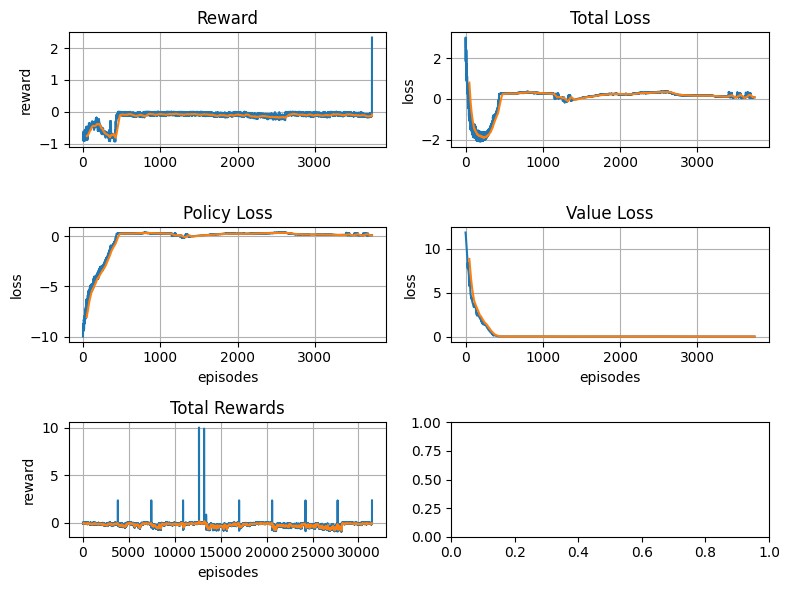


Actions Taken:
- SOUTH: 5583
- NORTH: 4794
- PICKUP: 5244
- EAT: 4676
- EAST: 5366
- DOWN: 4618
- WEST: 4633

Messages Received:
- Hello Agent, welcome to NetHack!  You are a neutral human Caveman.: 10
- : 9629
- There is nothing here to pick up.: 5120
- You dont have anything to eat.: 4676
- Its solid stone.: 9973
- The stairs are solidly fixed to the floor.: 121
- You cant go down here.: 4618
- You are beginning to feel hungry.: 10
- You are beginning to feel weak.: 9
- You faint from lack of food.  You regain consciousness.: 396
- You can hear again.: 117
- You regain consciousness.: 99
- The door resists!: 2
- The door opens.: 2
- Its a wall.: 118
- You see here a horn.: 10
- You see here an iron wand.: 1
- f - an iron wand.: 1
- g - a horn.: 1
- It wont come off the hinges.: 1


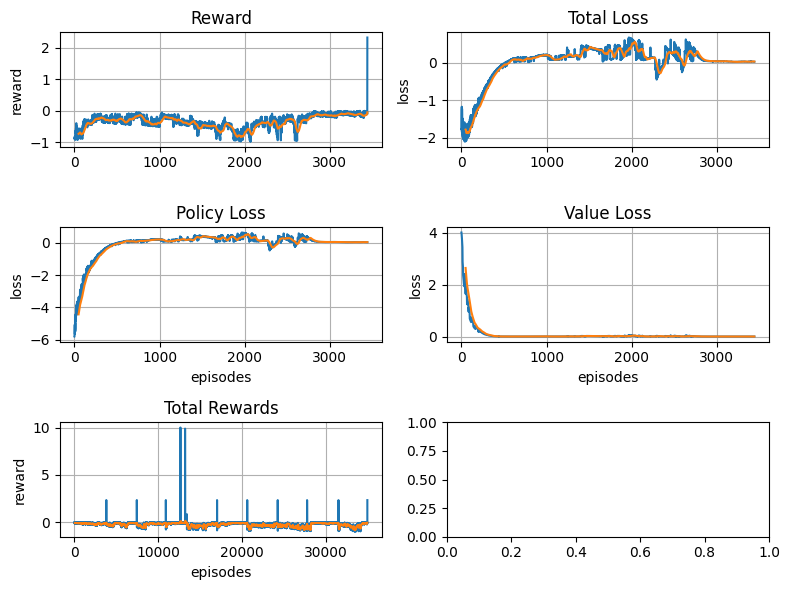


Actions Taken:
- SOUTH: 6151
- NORTH: 5275
- PICKUP: 5786
- EAT: 5135
- EAST: 5957
- DOWN: 5075
- WEST: 5103

Messages Received:
- Hello Agent, welcome to NetHack!  You are a neutral human Caveman.: 11
- : 10607
- There is nothing here to pick up.: 5658
- You dont have anything to eat.: 5135
- Its solid stone.: 11034
- The stairs are solidly fixed to the floor.: 125
- You cant go down here.: 5075
- You are beginning to feel hungry.: 11
- You are beginning to feel weak.: 10
- You faint from lack of food.  You regain consciousness.: 440
- You can hear again.: 130
- You regain consciousness.: 110
- The door resists!: 2
- The door opens.: 2
- Its a wall.: 118
- You see here a horn.: 10
- You see here an iron wand.: 1
- f - an iron wand.: 1
- g - a horn.: 1
- It wont come off the hinges.: 1


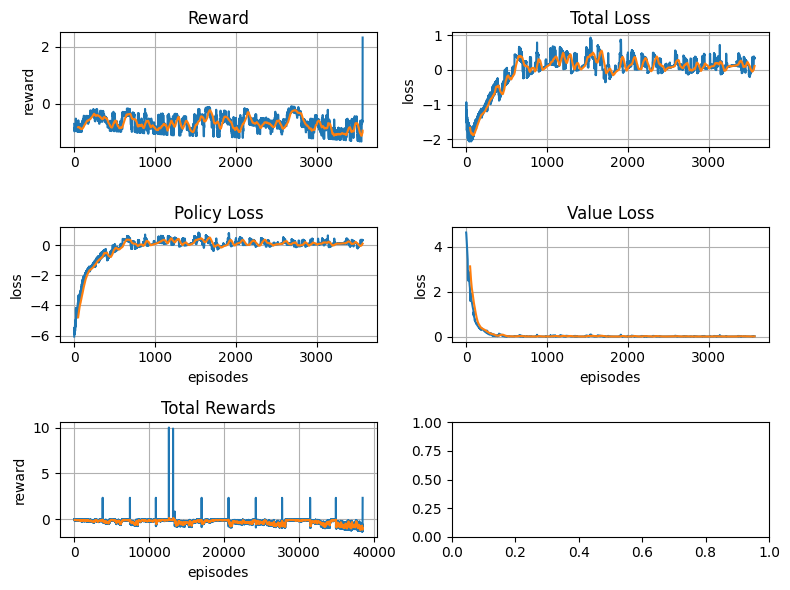


Actions Taken:
- SOUTH: 6732
- NORTH: 5769
- PICKUP: 6323
- EAT: 5596
- EAST: 6517
- DOWN: 5565
- WEST: 5591

Messages Received:
- Hello Agent, welcome to NetHack!  You are a neutral human Caveman.: 12
- : 11585
- There is nothing here to pick up.: 6193
- You dont have anything to eat.: 5596
- Its solid stone.: 12108
- The stairs are solidly fixed to the floor.: 127
- You cant go down here.: 5565
- You are beginning to feel hungry.: 12
- You are beginning to feel weak.: 11
- You faint from lack of food.  You regain consciousness.: 484
- You can hear again.: 143
- You regain consciousness.: 121
- The door resists!: 2
- The door opens.: 2
- Its a wall.: 118
- You see here a horn.: 10
- You see here an iron wand.: 1
- f - an iron wand.: 1
- g - a horn.: 1
- It wont come off the hinges.: 1


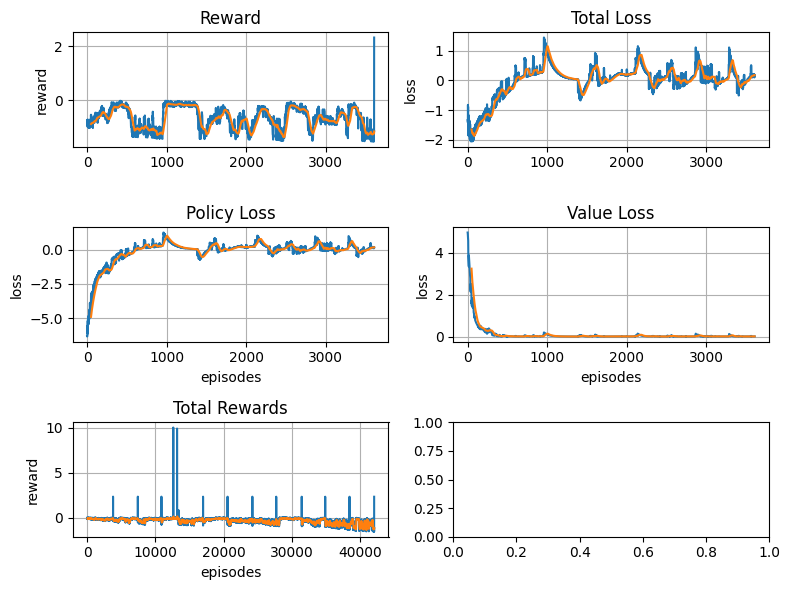


Actions Taken:
- SOUTH: 7271
- NORTH: 6232
- PICKUP: 6885
- EAT: 6108
- EAST: 7068
- DOWN: 6039
- WEST: 6074

Messages Received:
- Hello Agent, welcome to NetHack!  You are a neutral human Caveman.: 13
- : 12563
- There is nothing here to pick up.: 6739
- You dont have anything to eat.: 6108
- Its solid stone.: 13095
- The stairs are solidly fixed to the floor.: 143
- You cant go down here.: 6039
- You are beginning to feel hungry.: 13
- You are beginning to feel weak.: 12
- You faint from lack of food.  You regain consciousness.: 528
- You can hear again.: 156
- You regain consciousness.: 132
- The door resists!: 2
- The door opens.: 2
- Its a wall.: 118
- You see here a horn.: 10
- You see here an iron wand.: 1
- f - an iron wand.: 1
- g - a horn.: 1
- It wont come off the hinges.: 1


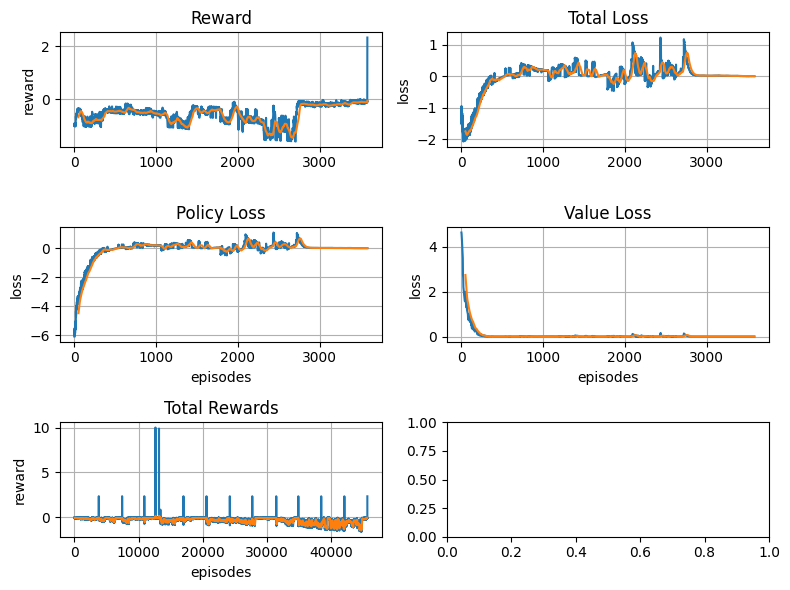


Actions Taken:
- SOUTH: 7841
- NORTH: 6759
- PICKUP: 7463
- EAT: 6620
- EAST: 7633
- DOWN: 6538
- WEST: 6553

Messages Received:
- Hello Agent, welcome to NetHack!  You are a neutral human Caveman.: 14
- : 13521
- There is nothing here to pick up.: 7314
- You dont have anything to eat.: 6620
- Its solid stone.: 14156
- The stairs are solidly fixed to the floor.: 144
- You cant go down here.: 6538
- You are beginning to feel hungry.: 14
- You are beginning to feel weak.: 13
- You faint from lack of food.  You regain consciousness.: 574
- You can hear again.: 177
- You regain consciousness.: 144
- The door resists!: 2
- The door opens.: 3
- Its a wall.: 153
- You see here a horn.: 12
- You see here an iron wand.: 2
- f - an iron wand.: 2
- g - a horn.: 1
- It wont come off the hinges.: 2
- You feel fragile!  You havent been watching your health.: 1


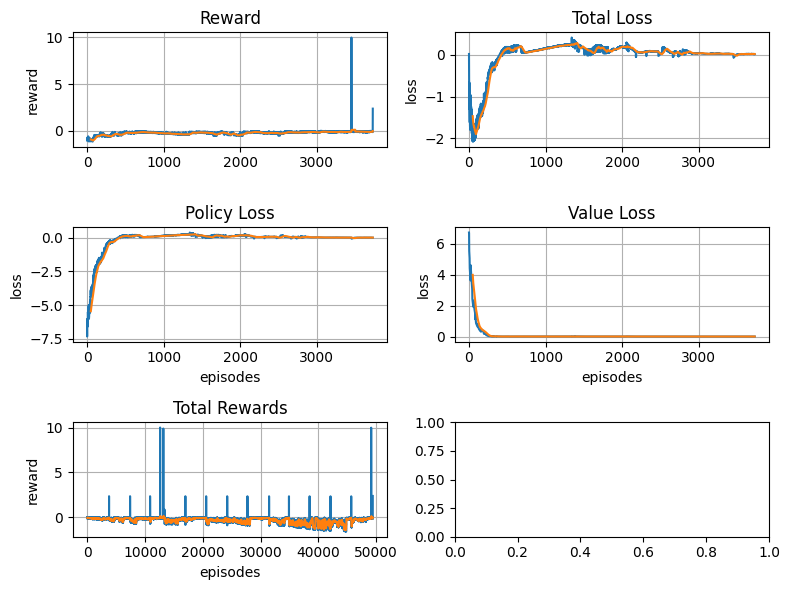

KeyboardInterrupt: 

In [11]:

# training
previous_description = ''
messages_received = dict()
actions_taken = dict()

Total_Rewards = []

for k in range(num_episodes):

    #visit_counts = dict()
    #coord_rewards = dict()

    obs = env.reset()
    
    done = False
    Actions, States, Rewards = [], [], []

    for h in range(max_steps):

        message = obs['message']
        msg = bytes(message)
        msg = str(msg).replace("'", "").replace('"', '').lstrip("b").rstrip("\\x00").rstrip("\x00")

        if msg not in messages_received:
            messages_received[msg] = 1
        else:
            messages_received[msg] += 1

        if verbose:
            print(msg[: msg.index(b"\0")])

        obs = convert_observation(obs)

        probs = nn.policy_net(obs)
        dist = torch.distributions.Categorical(probs = probs)
        action = dist.sample().item()

        obs_, rew, done, _ = env.step(action)

        stats = obs_['blstats']
        coords = (stats[0], stats[1])

        if action_text[action] not in actions_taken:
            actions_taken[action_text[action]] = 1
        else:
            actions_taken[action_text[action]] += 1

        if verbose:
            print( f"\rEpisode: {k+1}, Step: {h+1}, Coords: {coords}, Reward: {rew:0.4f}, Action: {action_text[action]}          ", end="")
        
        rew = rew + get_exploration_reward(obs_, rew)
        
        env.render()

        Actions.append(torch.tensor(action, dtype=torch.int))
        States.append(obs)
        Rewards.append(rew)

        # move to the next state
        obs = obs_

        if done:
            break

    DiscountedReturns = []
    r = 0
    # discount over the trajectory
    for step in reversed(range(len(Rewards))):
        r = Rewards[step] + gamma * r
        DiscountedReturns.insert(0, r)

    # normalize the returns?
    # ensure type 
    DiscountedReturns = np.array(DiscountedReturns)

    # calculate the mean and std
    mean = DiscountedReturns.mean(axis = 0)
    std = DiscountedReturns.std(axis = 0)

    # average and normalize the returns
    if std != 0.0:
        DiscountedReturns = (DiscountedReturns - mean) / std

    PolicyLoss = []
    ValueLoss = []
    TotalLoss = []
    
    for State, Action, G in zip(States, Actions, DiscountedReturns):

        value = nn.value_net(State)

        delta = G - value

        probs = nn.policy_net(State)
        policy_dist = torch.distributions.Categorical(probs = probs)
        log_probs = policy_dist.log_prob(Action)

        policy_loss = -( delta.detach() * log_probs )
        nn.policy_optimizer.zero_grad()
        policy_loss.backward()
        nn.policy_optimizer.step()

        pl = policy_loss.detach().numpy()
        PolicyLoss.append(pl)

        value_loss = torch.sum(delta**2) / 2
        nn.value_optimizer.zero_grad()
        value_loss.backward()
        nn.value_optimizer.step()

        vl = value_loss.detach().numpy()
        ValueLoss.append(vl)
        
        # probs = nn(State)
        # dist = torch.distributions.Categorical(probs=probs)    
        # log_prob = dist.log_prob(Action)
        
        # loss = -(log_prob*G)
        total_loss = pl + vl
        TotalLoss.append(total_loss)
        
        # optim.zero_grad()
        # loss.backward()
        # optim.step()

    Total_Rewards.extend(Rewards)

    if verbose:
        print( f"""
            Tot. Rewards: {np.sum(Rewards):0.4f}, Avg. Reward: {np.mean(Rewards):0.4f}, 
            Tot. Loss: {np.sum(TotalLoss):0.4f}, Avg Loss: {np.mean(TotalLoss):0.4f},
            Tot. Policy Loss: {np.sum(PolicyLoss):0.4f}, Avg Policy Loss: {np.mean(PolicyLoss):0.4f},
            Tot. Value Loss: {np.sum(ValueLoss):0.4f}, Avg Value Loss: {np.mean(ValueLoss):0.4f}
            """)

    # print("\nActions Taken:")
    # for key, val in actions_taken.items():
    #     print(f"- {key}: {val}")

    print("\nMessages Received:")
    for key, val in messages_received.items():
        print(f"- {key}: {val}")

    if intermediate_plots:

        PolicyLoss = np.reshape(PolicyLoss, (np.shape(PolicyLoss)[0], 1))
        ValueLoss = np.reshape(ValueLoss, (np.shape(ValueLoss)[0], 1))
        TotalLoss = np.reshape(TotalLoss, (np.shape(ValueLoss)[0], 1))

        #Plot stuff
        window = int(max_steps * 0.01)
        fig, axs = plt.subplots(3, 2)
        fig.set_figheight(6)
        fig.set_figwidth(8)

        #axs[0].plot(pd.DataFrame(Rewards))

        axs[0][0].title.set_text('Reward')
        #axs[0][0].set_xlabel('episodes')
        axs[0][0].set_ylabel('reward')
        axs[0][0].plot(pd.DataFrame(Rewards))
        axs[0][0].plot(pd.DataFrame(Rewards).rolling(window).mean())
        axs[0][0].grid(True)

        axs[0][1].title.set_text('Total Loss')
        #axs[0][1].set_xlabel('episodes')
        axs[0][1].set_ylabel('loss')
        axs[0][1].plot(pd.DataFrame(TotalLoss))
        axs[0][1].plot(pd.DataFrame(TotalLoss).rolling(window).mean())
        axs[0][1].grid(True)

        axs[1][0].title.set_text('Policy Loss')
        axs[1][0].set_xlabel('episodes')
        axs[1][0].set_ylabel('loss')
        axs[1][0].plot(pd.DataFrame(PolicyLoss))
        axs[1][0].plot(pd.DataFrame(PolicyLoss).rolling(window).mean())
        axs[1][0].grid(True)

        axs[1][1].title.set_text('Value Loss')
        axs[1][1].set_xlabel('episodes')
        axs[1][1].set_ylabel('loss')
        axs[1][1].plot(pd.DataFrame(ValueLoss))
        axs[1][1].plot(pd.DataFrame(ValueLoss).rolling(window).mean())
        axs[1][1].grid(True)

        axs[2][0].title.set_text('Total Rewards')
        axs[2][0].set_xlabel('episodes')
        axs[2][0].set_ylabel('reward')
        axs[2][0].plot(pd.DataFrame(Total_Rewards))
        axs[2][0].plot(pd.DataFrame(Total_Rewards).rolling(window).mean())
        axs[2][0].grid(True)

        fig.tight_layout()

        plt.show()

    
    